In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# General packages
import sys
import os
import math
import json
from pathlib import Path

In [3]:
# SciPy and Computing packages
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import sympy as sp
import sympy.abc as sym
import scipy as sci

from matplotlib.patches import RegularPolygon, Rectangle

In [4]:
# Configurations
sys.path.append('/rnsdhpc/code/Exnihilo/python')
%matplotlib inline

In [5]:
# Omnibus stuff
from exnihilotools.matplotlib import screen_style
screen_style()

In [6]:
import omnibus.formats.output as oo

# Roofline and FLOP analysis of Celeritas Klein-Nishina mini-app on the V100

*Tom Evans, 5-NOV-2020*

Here we are examining the `interactor_kn` kernel in the Klein-Nishina demo app.

To produce **nsight-compute** instrumented output run the [driver.py](./driver.py) script.  Then to produce roofline plots:
```
> python postprocess.py
```
Note that the roofline (`roofline.py` and `postprocess.py`) scripts are adapted and modified from [gitlab.com/NERSC](https://gitlab.com/NERSC/roofline-on-nvidia-gpus.git).

## Standard Output Data

In [7]:
home = Path('.')
alive = {}
for f in home.glob('track-npt-*'):
    with open(f, 'r') as out:
        d = json.load(out)
    
    npt = str(f).split('.')[0][-5:]
    alive[npt] = np.asarray(d['result']['alive'], dtype='int')

## FLOP and Performance Data

In [8]:
table1 = pd.read_csv('output-track-npt-1.csv', thousands=',')
table2 = pd.read_csv('output-track-npt-2.csv', thousands=',')
table4 = pd.read_csv('output-track-npt-4.csv', thousands=',')

In [9]:
table1.groupby(['ID']).get_group(0)['Metric Name']

0                                       dram__bytes.sum
1                                    l1tex__t_bytes.sum
2                                      lts__t_bytes.sum
3                                sm__cycles_elapsed.avg
4                     sm__cycles_elapsed.avg.per_second
5     sm__sass_thread_inst_executed_op_dadd_pred_on.sum
6     sm__sass_thread_inst_executed_op_dfma_pred_on.sum
7     sm__sass_thread_inst_executed_op_dmul_pred_on.sum
8     sm__sass_thread_inst_executed_op_fadd_pred_on.sum
9     sm__sass_thread_inst_executed_op_ffma_pred_on.sum
10    sm__sass_thread_inst_executed_op_fmul_pred_on.sum
11    sm__sass_thread_inst_executed_op_hadd_pred_on.sum
12    sm__sass_thread_inst_executed_op_hfma_pred_on.sum
13    sm__sass_thread_inst_executed_op_hmul_pred_on.sum
Name: Metric Name, dtype: object

In [10]:
def generate(table):
    idtable = table.groupby(['ID'])
    
    flops = []
    for name, group in idtable:
        m = group['Metric Value']
        time = m.iloc[3] / m.iloc[4]
        f = m.iloc[5] + 2.0*m.iloc[6] + m.iloc[7] + \
            m.iloc[8] + 2.0*m.iloc[9] + m.iloc[10] + \
            m.iloc[11] + 2.0*m.iloc[12] + m.iloc[13]
        flops.append(f/time/2**30)
    flops = np.asarray(flops)
    
    return flops

In [11]:
def histogram(ax, flops):
    c,b,p = ax.hist(flops, bins=200, density=False, edgecolor='black', linewidth=.1,  label='iterate_kn')
    ax.set_xlabel('Performance [GFLOP/sec]')
    ax.grid()
    ax.legend(frameon=True)

In [12]:
def steps(ax, flops, labels):

    step = np.arange(82)
    
    for flop, label in zip(flops, labels):
        ax.plot(step, flop, ds='steps-post', label=label)
    ax.grid()

    ax.set_xlabel("Step")
    ax.set_ylabel("Performance [GFLOP/sec]")
    ax.tick_params(axis='y')

    ox = ax.twinx()

    ox.plot(step, alive['npt-1'][:-1], color='red', ds='steps-post')
    ox.set_ylabel("Tracks per step", color='red')
    ox.tick_params(axis='y', labelcolor='red')
    ox.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.legend(frameon=True, loc='center left')

In [13]:
flops1 = generate(table1)
flops2 = generate(table2)
flops4 = generate(table4)

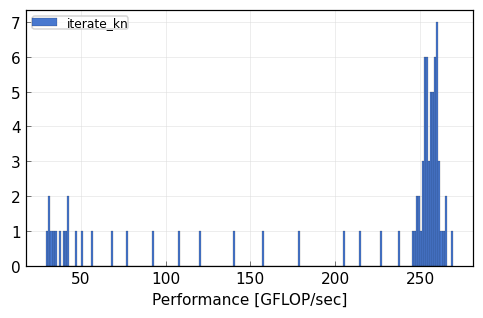

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
histogram(ax, flops1)
fig.tight_layout()

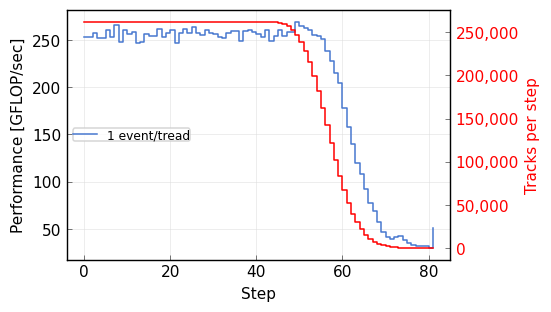

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
steps(ax, [flops1], ['1 event/tread'])

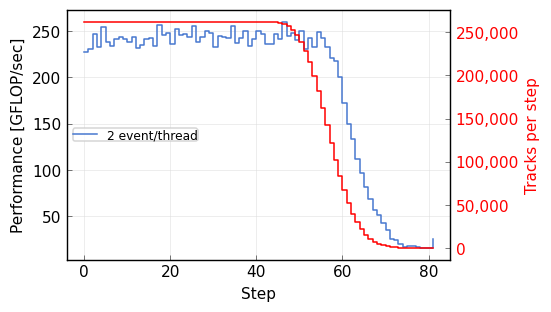

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
steps(ax, [flops2], ['2 event/thread'])

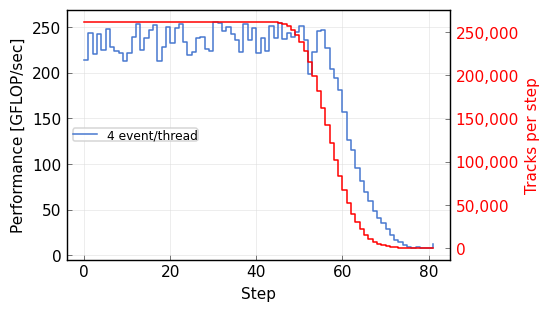

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
steps(ax, [flops4], ['4 event/thread'])

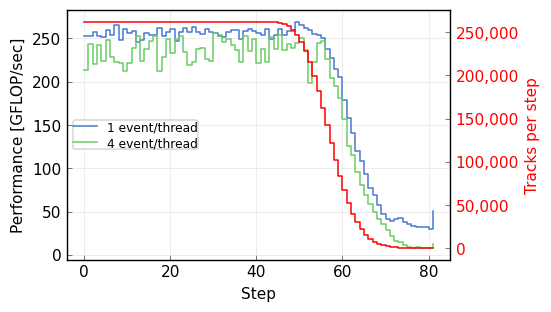

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
steps(ax, [flops1, flops4], ['1 event/thread', '4 event/thread'])
fig.savefig('flops-per-step.pdf', bbox_inches='tight')

## Register and Occupancy

In [19]:
with open('track-npt-1.json', 'r') as out:
    diag = json.load(out)['diagnostics']

In [20]:
table = pd.DataFrame(diag, index=diag['kernel'], columns=['occupancy', 'registers'])

In [21]:
table

,occupancy,registers
demo_interactor::iterate_kn,0.375,69
demo_interactor::initialize_kn,1.000,20
